# <a name="0">Project Day 2</a>

__Dataset:__ Sentiment (positive or negative) analysis of movie reviews. The dataset is originally hosted [here](http://ai.stanford.edu/~amaas/data/sentiment/).

In this notebook you will be asked to implement a Recurrent Neural Networks (RNNs) to predict the sentiment of review texts. 

Use the notebooks from the class and implement the model, train and test with the IMDB datasets.
You can follow these steps:
1. Read training-test data 
2. Create Word Embeddings
3. Set up the RNN & parameters
4. Train a classifier 
5. Make predictions on your test dataset

In [1]:
!pip install -q torch==1.8.1 torchtext nltk

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import re, time
import numpy as np
import torch, torchtext
import boto3
import os
import matplotlib.pyplot as plt
import pandas as pd

from os import path
from collections import Counter
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchtext.vocab import GloVe

## 1. Reading the dataset

We will use the __pandas__ library to read our dataset.

#### __Training data:__

In [3]:
import pandas as pd

train_df = pd.read_csv('../../DATA/final_project/imdb_train.csv', encoding='latin1', header=0)
train_df.head()

text  label
0  This movie makes me want to throw up every tim...    0.0
1  Listening to the director's commentary confirm...    0.0
2  One of the best Tarzan films is also one of it...    1.0
3  Valentine is now one of my favorite slasher fi...    1.0
4  No mention if Ann Rivers Siddons adapted the m...    0.0

#### __Test data:__

In [4]:
import pandas as pd

test_df = pd.read_csv('../../DATA/final_project/imdb_test.csv', encoding='latin1', header=0)
test_df.head()

text  label
0  What I hoped for (or even expected) was the we...      0
1  Garden State must rate amongst the most contri...      0
2  There is a lot wrong with this film. I will no...      1
3  To qualify my use of "realistic" in the summar...      1
4  Dirty War is absolutely one of the best politi...      1

## 2. Create Word Embeddings

Before we create word embeddings, let's check if there are any missing values:

In [5]:
train_df.isna().sum()

text     0
label    1
dtype: int64

To be on the safe side, let's drop the missing value row:

In [6]:
# Drop all rows where there are missing values (could also target a specific column with subset)
train_df.dropna(inplace = True, axis = 0)

# Let's also repeat this for the test df
test_df.dropna(inplace = True, axis = 0)

As final check, we look at the distribution of the target.

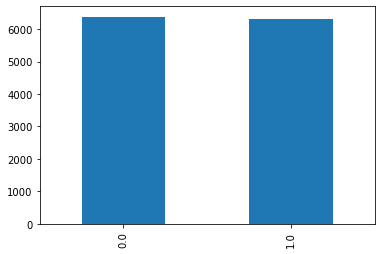

In [7]:
train_df['label'].value_counts().plot.bar()
plt.show()

To work with language data, you will first need to convert to a numerical representation. User GloVe or BERT for this step.

Complete the following steps:
1. Split your data between train and validation (no need to repeat for test as we already have a seperate file for this) using the sklearn `train_test_split` method. Use a 90/10 split.
2. Loop through your training dataset corpus (in this case the corpus is the `text` column) and find all unique tokens by applying  the `.get_tokenizer("basic_english")` method
3. Generate the vocabulary (list of all unique tokens) with `Vocab` and the tokens + count of tokens from the previous step. Only keep words that appear at least twice.

In [8]:
# Implement code here


# This separates 10% of the entire dataset into validation dataset.
X_train, X_val, y_train, y_val = \
    train_test_split(train_df["text"].tolist(),
                     train_df["label"].tolist(),
                     test_size=0.10,
                     shuffle=True,
                     random_state=324)


# Convert everything to tokens
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in X_train:
    counter.update(tokenizer(line))
    
vocab = Vocab(counter, min_freq=2)

Let's create a mapper to transform our text data:

In [9]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

Print the first 10 words and tokens for the first sentence in the train dataset:

In [10]:
print(f"Before transform:\t{X_train[1].split()[:10]}")
print(f"After transform:\t{text_transform_pipeline(X_train[1])[:10]}")

Before transform:	['this', 'may', 'not', 'be', 'War', '&', 'Peace,', 'but', 'the', 'two']
After transform:	[14, 212, 29, 34, 356, 191, 2365, 4, 22, 2]


Let's place the mapper (`text_transform_pipeline`) into a function that we can apply to the whole dataset.

In [11]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.zeros(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

Let's use the `transformText()` function and create the data loaders. Here, we use `max_len=100` to consider the first 100 words in the text. If there are reviews that are shorter than 100 words, they will be padded with 0s.

For the `DataLoader` we will use a batch size of 16.

In [12]:
max_len = 100
batch_size = 16

# Pass transformed and padded data to dataset
train_dataset = TensorDataset(transformText(X_train, max_len), torch.tensor(y_train))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(transformText(X_val, max_len), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Let's load in the embeddings based on the vocabulary we created from our corpus using GloVe. 
As embedding vector size, we use 50.

In [13]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=50)
embedding_matrix = glove.get_vecs_by_tokens(vocab.itos)

## 3. Set up the RNN & parameters

Generally, it is good practice to delete any model artifacts before going into the training section. Otherwise we might be using parameters gradients from previous executions.

In [14]:
try:
    del model
except:
    pass

Now set all the parameters up that your NN architecure requires. You will need the size of the hidden layers, learning rate, epochs, the embedding and also the total vocabulary size (as for every word in the vocabulary we need to create an embedding).

In [15]:
# Implement code here

# Size of the state vectors
hidden_size = 8

# General NN training parameters
learning_rate = 0.01
epochs = 25

# Embedding vector and vocabulary sizes
embed_size = 50  # glove.6B.50d.txt
vocab_size = len(vocab.itos)

Now, use the architecture from class for the RNN.

```
class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(
            embed_size, hidden_size, num_layers=num_layers
        )

        self.linear = nn.Linear(hidden_size*max_len, 1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        # Call RNN layer
        outputs, _ = self.rnn(embeddings)
        # Use the output of each time step
        # Send it all together to the linear layer
        outs = self.linear(outputs.reshape(outputs.shape[0], -1))
        return self.act(outs)

model = Net(vocab_size, embed_size, hidden_size, num_layers=2)
```

In [16]:
class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(
            embed_size, hidden_size, num_layers=num_layers
        )

        self.linear = nn.Linear(hidden_size*max_len, 1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        # Call RNN layer
        outputs, _ = self.rnn(embeddings)
        # Use the output of each time step
        # Send it all together to the linear layer
        outs = self.linear(outputs.reshape(outputs.shape[0], -1))
        return self.act(outs)
    
model = Net(vocab_size, embed_size, hidden_size, num_layers=2)

To train the RNN, you need to loop over the training batches in epochs. Don't forget to apply the weights to the net and make sure you send all data & the net itself to CPU or GPU with `.to(device)`.

In [17]:
# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
                
model.apply(init_weights)
model.to(device)

Net(
  (embedding): Embedding(35955, 50)
  (rnn): RNN(50, 8, num_layers=2)
  (linear): Linear(in_features=800, out_features=1, bias=True)
  (act): Sigmoid()
)

Specifically for RNNs, you need to make sure the embedding layer uses your word vectors. The implementation for this depends slightly on the embedding library you are using. For GloVe, the syntax is show here:

```
# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False

```

In [18]:
# implement code here

# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False

As final step for set up, you need to decide on the optimization method for your NN as well as a loss function that matches the problem type.

In this example, the problem is a binary classification (positive review or not) so log loss can be used.

In [19]:
# Setting our trainer
trainer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
cross_ent_loss = nn.BCEWithLogitsLoss(reduction='none') 

If you want to change the [optimizer](https://pytorch.org/docs/stable/optim.html) or the loss function, have a look at the Pytorch documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

## 4. Train a classifier

To train the RNN, you will need some initial weights. Again, Pytorch has different options for this. You can start with random weights, all 0s, all 1s or custom values.

In [20]:
for data, target in train_loader:
    d = data
    t = target
d.shape, t.shape

(torch.Size([5, 100]), torch.Size([5]))

In [21]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    val_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):
        trainer.zero_grad()
        output = model(data.to(device))
        L = cross_ent_loss(output, target.to(device).unsqueeze(1)).sum()
        training_loss += L.item()
        L.backward()
        trainer.step()

    # Validate the network, no training (no weight update)
    for data, target in val_loader:
        val_predictions = model(data.to(device))
        L = cross_ent_loss(val_predictions, target.to(device).unsqueeze(1)).sum()
        val_loss += L.item()

    # Let's take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    # For plotting, add current value at epoch to list
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Val_loss {val_loss}. Seconds {end-start}"
    )

Epoch 0. Train_loss 0.6932140581553295. Val_loss 0.6930994393789834. Seconds 2.4019956588745117
Epoch 1. Train_loss 0.6930341666475726. Val_loss 0.693030549373281. Seconds 2.41812801361084
Epoch 2. Train_loss 0.6927182773009176. Val_loss 0.6927607493479483. Seconds 2.4159934520721436
Epoch 3. Train_loss 0.6907437746587272. Val_loss 0.6888550885368089. Seconds 2.3970417976379395
Epoch 4. Train_loss 0.677516652231493. Val_loss 0.6748732254202672. Seconds 2.3707451820373535
Epoch 5. Train_loss 0.6646478658469085. Val_loss 0.6684755660869457. Seconds 2.3565263748168945
Epoch 6. Train_loss 0.6569431216859027. Val_loss 0.6653777070642927. Seconds 2.3901004791259766
Epoch 7. Train_loss 0.6513687880567943. Val_loss 0.6595794991116716. Seconds 2.3779752254486084
Epoch 8. Train_loss 0.6468626603668247. Val_loss 0.6578800249888823. Seconds 2.38285493850708
Epoch 9. Train_loss 0.6430358474557305. Val_loss 0.6574334547780836. Seconds 2.3773577213287354
Epoch 10. Train_loss 0.6405915383399342. Val_l

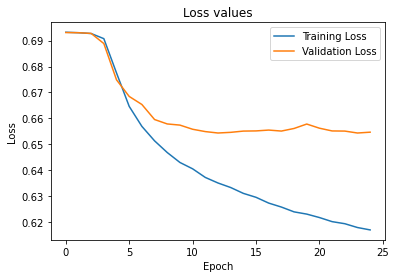

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 5. Make predictions on your test dataset

You now have a trained RNN that you can use to make predictions. Use the test dataframe you loaded in at the top of the notebook.

In [22]:
test_text = test_df["text"].fillna(value='').tolist()

In [23]:
test_dataset = TensorDataset(transformText(test_text, max_len))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [24]:
test_predictions = []
for data, in test_loader:
    test_preds = model(data.to(device))
    test_predictions.extend(
        [np.rint(test_pred)[0] for test_pred in test_preds.detach().cpu().numpy()]
    )
print(test_predictions[:10])

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


Compare the predictions to the true test labels.

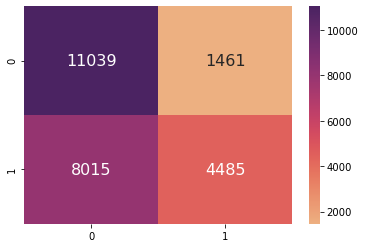

In [25]:
sns.heatmap(confusion_matrix(test_df['label'].values, test_predictions)
            , annot=True
            , annot_kws={"size": 16}
            , cmap =  "flare"
            ,  fmt='d')
plt.show()

In [26]:
print(classification_report(test_df['label'].values, test_predictions))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70     12500
           1       0.75      0.36      0.49     12500

    accuracy                           0.62     25000
   macro avg       0.67      0.62      0.59     25000
weighted avg       0.67      0.62      0.59     25000

